# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

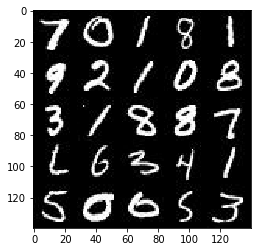

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

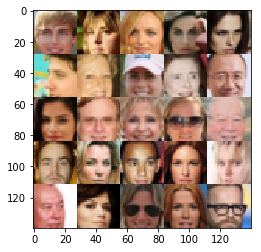

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests
import numpy as np

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, shape = [None, image_height, image_width,image_channels], name="inputs")
    z_dim = tf.placeholder(tf.float32, shape = [None, z_dim], name="z_dim")
    learning_rate = tf.placeholder(tf.float32, shape = None, name="learning_rate")
    return inputs, z_dim, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    ims = images.get_shape().as_list()
    print(ims)
    ims = np.product(ims[1:])
    alpha = 0.1
    
    with tf.variable_scope("discriminator",
                           reuse = reuse):
        discriminator = images
        if(not reuse):print("discriminator ", discriminator.get_shape().as_list())
        
        discriminator = tf.layers.conv2d (discriminator, 64, (5,5), strides=(2,2), activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        discriminator = tf.maximum(discriminator, tf.multiply(alpha, discriminator))
        if(not reuse):print("discriminator ", discriminator.get_shape().as_list())
        
        discriminator = tf.layers.conv2d (discriminator, 128, (5,5), strides=(1,1), activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        discriminator = tf.maximum(discriminator, tf.multiply(alpha, discriminator))
        if(not reuse):print("discriminator ", discriminator.get_shape().as_list())
        
        discriminator = tf.layers.conv2d (discriminator, 248, (5,5), strides=(1,1), activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        discriminator = tf.maximum(discriminator, tf.multiply(alpha, discriminator))
        if(not reuse):print("discriminator ", discriminator.get_shape().as_list())
        
        ims=np.product(discriminator.get_shape().as_list()[1:])
        discriminator = tf.reshape(discriminator, [-1, ims])
        
        if(not reuse):print("ds flat: ",discriminator.get_shape().as_list())
        discriminator = tf.contrib.layers.fully_connected(
            discriminator, num_outputs= int(ims*0.5), activation_fn = None)
        discriminator = tf.maximum(discriminator, tf.multiply(alpha, discriminator))
        
        discriminator = tf.layers.dense(
            discriminator, 1, activation = None)
        
        if(not reuse):print("ds out: ",discriminator.get_shape().as_list())
        out = tf.tanh( discriminator )
    return out, discriminator


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

[None, 28, 28, 3]
discriminator  [None, 28, 28, 3]
discriminator  [None, 12, 12, 64]
discriminator  [None, 8, 8, 128]
discriminator  [None, 4, 4, 248]
ds flat:  [None, 3968]
ds out:  [None, 1]
[None, 28, 28, 3]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
import numpy as np
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    imside = 28
    ims = imside*imside*out_channel_dim
    alpha = 0.1
    with tf.variable_scope("generator",
                           reuse = not is_train):
        out = z
        #generator = tf.contrib.layers.fully_connected( generator, num_outputs= int(ims*2), activation_fn = None)
        #generator = tf.maximum(generator, tf.multiply(0.01, generator))
        
        #generator = tf.contrib.layers.fully_connected(generator, num_outputs= int(ims*0.25), activation_fn = None)
        #generator = tf.maximum(generator, tf.multiply(0.01, generator))
    
        noise_shape = [-1, 2, 2, 25]
        out = tf.contrib.layers.fully_connected(
            out, num_outputs = int(np.product(noise_shape[1:])), activation_fn = None)
        out = tf.maximum(out, tf.multiply(alpha, out))
        
        out = tf.reshape(out, noise_shape)
        out = tf.layers.conv2d_transpose(out, 512,  5, 2, padding="valid", 
                                         activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.layers.batch_normalization(out, training=is_train)        
        out = tf.maximum(out, tf.multiply(alpha, out))
        if (is_train): print("gen: ",out.get_shape().as_list()) 
        
        out = tf.layers.conv2d_transpose(out, 256, 5, 2, padding="same", 
                                         activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.layers.batch_normalization(out, training=is_train)        
        out = tf.maximum(out, tf.multiply(alpha, out))        
        if (is_train): print("gen: ",out.get_shape().as_list())
        
        out = tf.layers.conv2d_transpose(out, 128, 5, 2, padding="same", activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        out = tf.layers.batch_normalization(out, training=is_train)        
        out = tf.maximum(out, tf.multiply(alpha, out))        
        if (is_train): print("gen: ",out.get_shape().as_list())
                
        out = tf.layers.conv2d_transpose(out, out_channel_dim, 5, 1, padding="same", 
                                         activation=None,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
                
        out = tf.tanh( out  )
        if (is_train): print("gen: ",out.get_shape().as_list())
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

gen:  [None, 7, 7, 512]
gen:  [None, 14, 14, 256]
gen:  [None, 28, 28, 128]
gen:  [None, 28, 28, 5]
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    geneo = generator(input_z, out_channel_dim)
    discor, disclr = discriminator(input_real)
    discof, disclf = discriminator(geneo, reuse = True)
    
    dislossr = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disclr, 
            labels=0.9*tf.ones_like(disclr)))
    
    dislossf = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disclf, 
            labels=tf.zeros_like(disclf)))
    
    disloss = dislossf + dislossr
    
    genloss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disclf, 
            labels=tf.ones_like(disclf)))
    
    
    return disloss, genloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

gen:  [None, 7, 7, 512]
gen:  [None, 14, 14, 256]
gen:  [None, 28, 28, 128]
gen:  [None, 28, 28, 4]
[None, 28, 28, 4]
discriminator  [None, 28, 28, 4]
discriminator  [None, 12, 12, 64]
discriminator  [None, 8, 8, 128]
discriminator  [None, 4, 4, 248]
ds flat:  [None, 3968]
ds out:  [None, 1]
[None, 28, 28, 4]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable = tf.trainable_variables()
    genew = [ w for w in trainable 
             if "generator/" in w.name]
    
    discw = [ w for w in trainable 
             if "discriminator/" in w.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        genewTo = tf.train.AdamOptimizer(
            learning_rate, beta1 = beta1).minimize(
            g_loss, var_list=genew)

        discwTo = tf.train.AdamOptimizer(
            learning_rate, beta1 = beta1).minimize(
            d_loss, var_list=discw)

    return discwTo, genewTo


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import time
import tqdm

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    input_channels = data_shape[3] #int(3 if data_image_mode == "RGB" else 1) 
    
    print ("input channels: ", input_channels,", data_shape: ", data_shape)
    input_real, input_z, learning_rt = model_inputs(
        data_shape[1], data_shape[2], input_channels, z_dim)
          
    
    d_loss,  g_loss = model_loss(input_real, input_z, input_channels)
    d_train, g_train = model_opt(d_loss, g_loss, learning_rt, beta1)
    start_time = time.time()
    saver = tf.train.Saver()
    i=0
    #!mkdir "./savedmodel"  
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                i=i+1
                #saver.save(sess, './savedmodel/model.ckpt')
                #fileWriter = tf.summary.FileWriter("./savedmodel", graph=sess.graph)
                #fileWriter.flush()
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print("batch shape z:", batch_z.shape, " im:", batch_images.shape)
                
                
                sess.run(d_train, feed_dict = {
                    input_real: batch_images,
                    input_z: batch_z,
                    learning_rt: learning_rate
                })
                
                sess.run(g_train, feed_dict = {
                    input_z: batch_z,
                    learning_rt: learning_rate
                })
                if(0 == i % 100):
                    d_accute_loss = sess.run(d_loss, feed_dict = {
                        input_real: batch_images,
                        input_z: batch_z
                    })

                    g_accute_loss = sess.run(g_loss, feed_dict = {
                        input_z: batch_z
                    })

                    tspan = (time.time()-start_time)/60
                    eta = (int(data_shape[0] * tspan/(i*batch_size)))
                    print("\r Ep: {:03d}/{:3d} DL:{:.4f} GL:{:.4f} time:{:d}/{:d} min ".format(
                        epoch_i, epoch_count, d_accute_loss, g_accute_loss, int(tspan), eta), i)

                    show_generator_output(sess, 16, input_z, input_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

input channels:  1 , data_shape:  (60000, 28, 28, 1)
gen:  [None, 7, 7, 512]
gen:  [None, 14, 14, 256]
gen:  [None, 28, 28, 128]
gen:  [None, 28, 28, 1]
[None, 28, 28, 1]
discriminator  [None, 28, 28, 1]
discriminator  [None, 12, 12, 64]
discriminator  [None, 8, 8, 128]
discriminator  [None, 4, 4, 248]
ds flat:  [None, 3968]
ds out:  [None, 1]
[None, 28, 28, 1]
 Ep: 000/  2 DL:1.1154 GL:1.1936 time:0/3 min  100


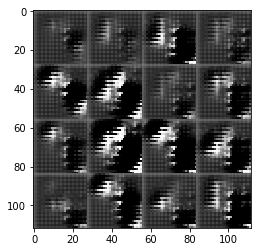

 Ep: 000/  2 DL:0.9228 GL:1.1348 time:0/3 min  200


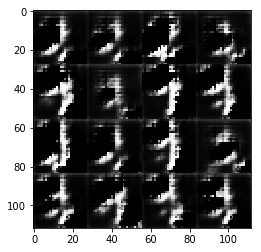

 Ep: 000/  2 DL:0.8831 GL:1.8540 time:1/3 min  300


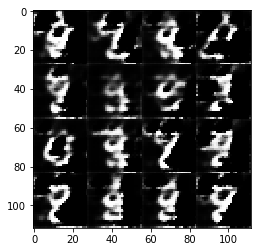

 Ep: 000/  2 DL:1.2300 GL:2.9480 time:1/3 min  400


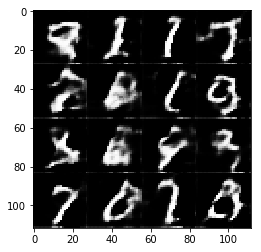

 Ep: 000/  2 DL:0.9902 GL:1.6997 time:1/3 min  500


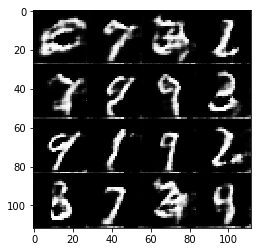

 Ep: 000/  2 DL:0.7662 GL:1.8271 time:2/3 min  600


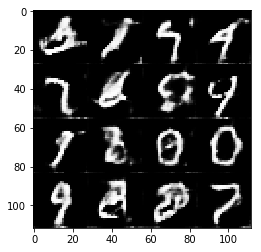

 Ep: 000/  2 DL:0.9293 GL:1.3076 time:2/3 min  700


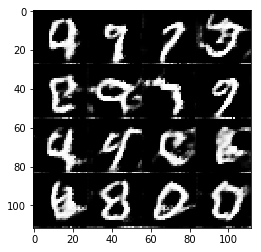

 Ep: 000/  2 DL:0.8290 GL:1.5059 time:2/3 min  800


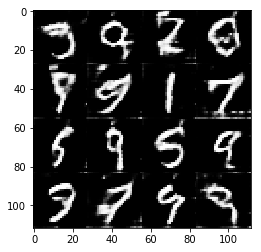

 Ep: 000/  2 DL:0.8227 GL:1.4928 time:3/3 min  900


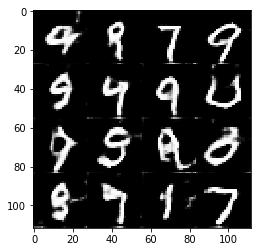

 Ep: 001/  2 DL:0.9145 GL:1.3632 time:3/3 min  1000


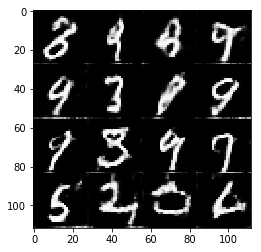

 Ep: 001/  2 DL:0.7182 GL:1.8279 time:3/3 min  1100


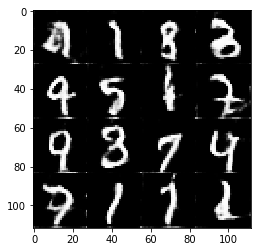

 Ep: 001/  2 DL:0.9352 GL:1.1753 time:4/3 min  1200


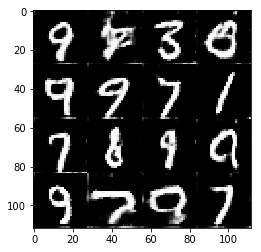

 Ep: 001/  2 DL:1.0218 GL:1.1151 time:4/3 min  1300


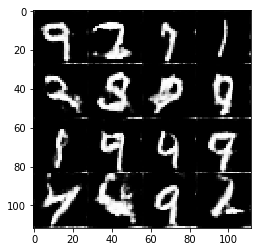

 Ep: 001/  2 DL:0.9873 GL:1.1304 time:4/3 min  1400


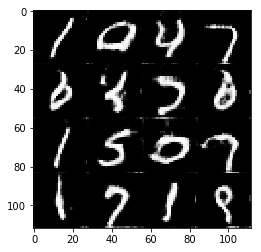

 Ep: 001/  2 DL:1.0248 GL:1.1415 time:5/3 min  1500


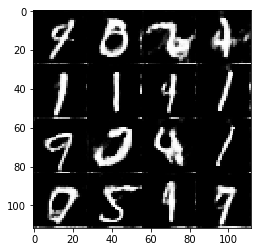

 Ep: 001/  2 DL:0.9666 GL:1.1773 time:5/3 min  1600


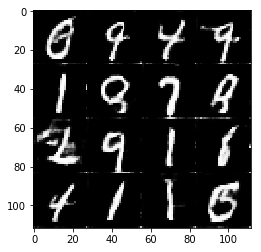

 Ep: 001/  2 DL:0.9166 GL:1.2898 time:5/3 min  1700


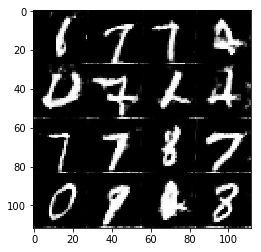

 Ep: 001/  2 DL:1.0233 GL:1.0682 time:6/3 min  1800


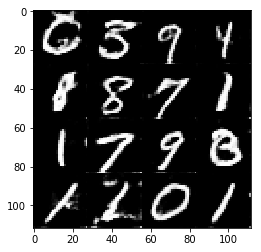

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0013
beta1 = 0.45
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.set_random_seed(5)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

input channels:  3 , data_shape:  (202599, 28, 28, 3)
gen:  [None, 7, 7, 512]
gen:  [None, 14, 14, 256]
gen:  [None, 28, 28, 128]
gen:  [None, 28, 28, 3]
[None, 28, 28, 3]
discriminator  [None, 28, 28, 3]
discriminator  [None, 12, 12, 64]
discriminator  [None, 8, 8, 128]
discriminator  [None, 4, 4, 248]
ds flat:  [None, 3968]
ds out:  [None, 1]
[None, 28, 28, 3]
 Ep: 000/  1 DL:1.1139 GL:1.1287 time:0/20 min  100


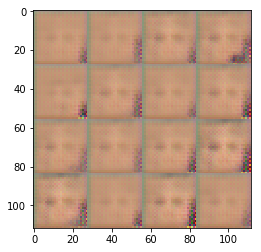

 Ep: 000/  1 DL:0.8504 GL:2.0435 time:1/20 min  200


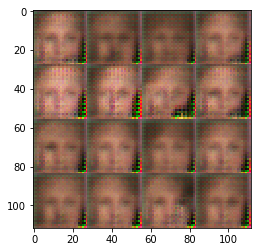

 Ep: 000/  1 DL:1.1295 GL:1.2847 time:1/20 min  300


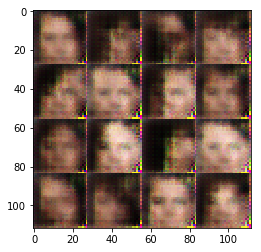

 Ep: 000/  1 DL:0.9933 GL:1.1135 time:2/20 min  400


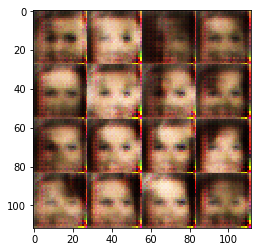

 Ep: 000/  1 DL:0.8863 GL:1.2257 time:3/20 min  500


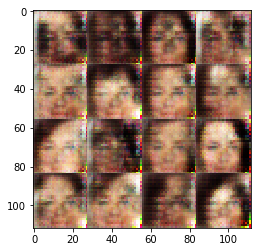

 Ep: 000/  1 DL:1.0005 GL:1.1733 time:3/20 min  600


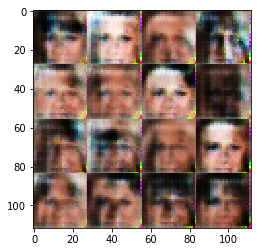

 Ep: 000/  1 DL:1.0906 GL:1.4623 time:4/20 min  700


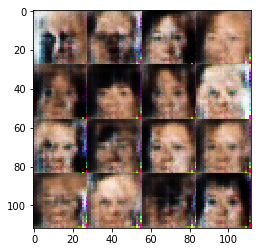

 Ep: 000/  1 DL:0.9867 GL:1.2840 time:5/20 min  800


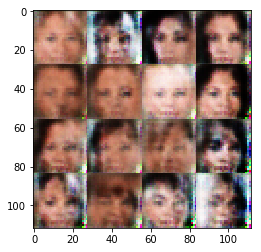

 Ep: 000/  1 DL:1.0083 GL:1.2364 time:5/20 min  900


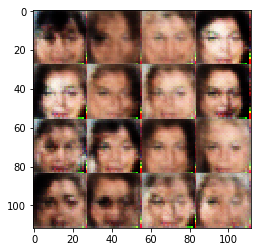

 Ep: 000/  1 DL:1.0895 GL:1.1558 time:6/20 min  1000


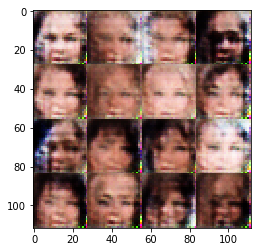

 Ep: 000/  1 DL:0.9608 GL:1.3100 time:6/20 min  1100


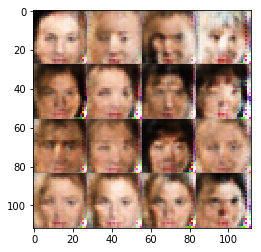

 Ep: 000/  1 DL:1.1339 GL:1.0440 time:7/20 min  1200


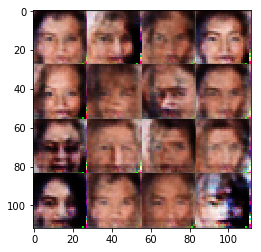

 Ep: 000/  1 DL:1.2048 GL:0.8172 time:8/20 min  1300


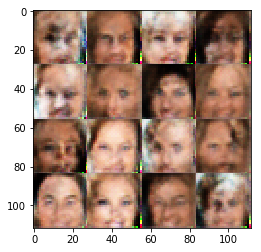

 Ep: 000/  1 DL:1.1808 GL:1.0209 time:8/20 min  1400


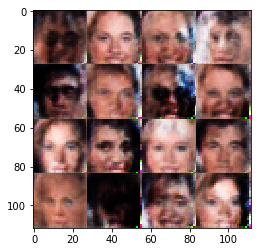

 Ep: 000/  1 DL:1.0422 GL:1.2817 time:9/20 min  1500


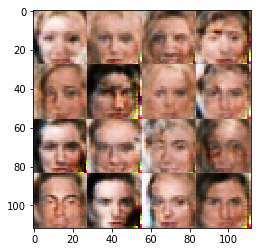

 Ep: 000/  1 DL:1.1871 GL:1.1431 time:10/20 min  1600


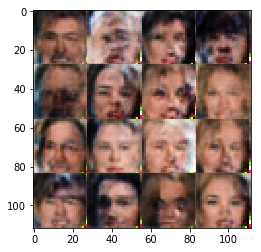

 Ep: 000/  1 DL:1.1584 GL:0.9065 time:10/20 min  1700


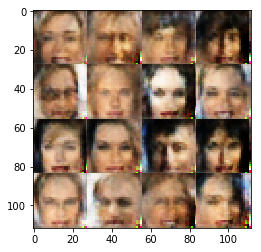

 Ep: 000/  1 DL:1.2196 GL:1.3609 time:11/20 min  1800


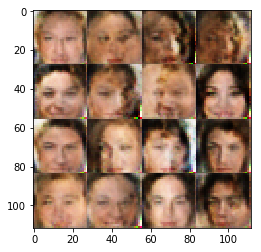

 Ep: 000/  1 DL:1.0487 GL:1.2961 time:12/20 min  1900


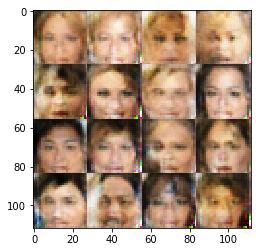

 Ep: 000/  1 DL:1.0745 GL:1.2575 time:12/20 min  2000


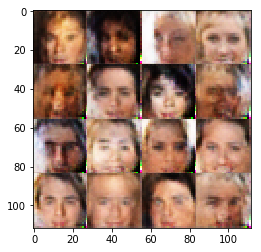

 Ep: 000/  1 DL:1.0586 GL:1.1534 time:13/20 min  2100


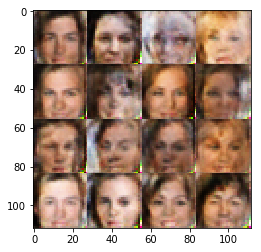

 Ep: 000/  1 DL:1.1791 GL:0.9375 time:14/20 min  2200


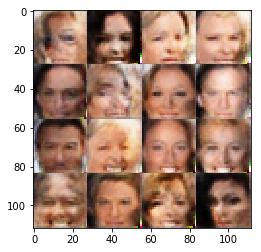

 Ep: 000/  1 DL:1.1564 GL:1.1065 time:14/20 min  2300


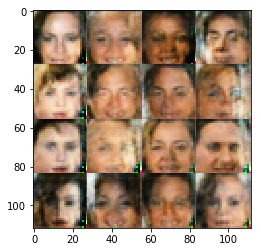

 Ep: 000/  1 DL:1.1036 GL:0.9770 time:15/20 min  2400


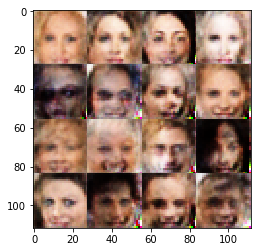

 Ep: 000/  1 DL:1.1138 GL:1.0384 time:16/20 min  2500


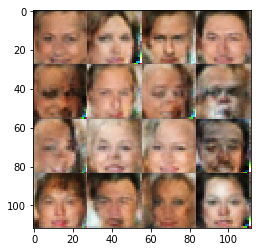

 Ep: 000/  1 DL:1.0687 GL:1.0879 time:16/20 min  2600


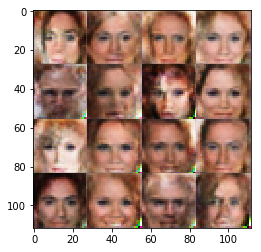

 Ep: 000/  1 DL:1.1653 GL:1.0317 time:17/20 min  2700


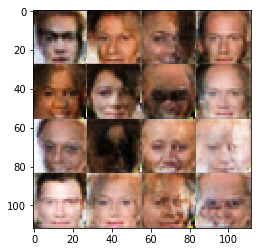

 Ep: 000/  1 DL:1.1617 GL:1.0782 time:17/20 min  2800


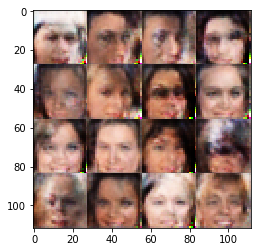

 Ep: 000/  1 DL:1.2361 GL:0.8908 time:18/20 min  2900


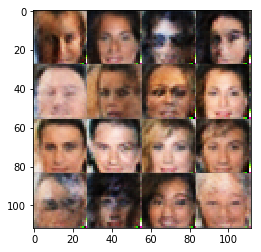

 Ep: 000/  1 DL:1.1571 GL:1.1245 time:19/20 min  3000


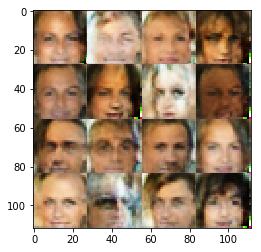

 Ep: 000/  1 DL:1.2670 GL:0.9292 time:19/19 min  3100


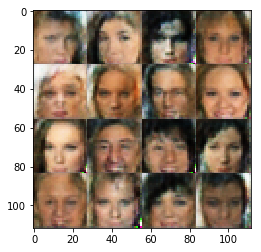

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.45
tf.set_random_seed(5)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.